<a href="https://colab.research.google.com/github/fazekas-gergo/composer-ai/blob/master/ComposerAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Composer AI
Authors: Fazekas Gergő and Joseph Tadrous<br>
Used dataset: https://www.kaggle.com/soumikrakshit/classical-music-midi

---
## 1. First steps
At first clone the repository, which contains the raw dataset and the created dataframe (which was created in the *Create_DataFrame.ipynb* file).<br>
Then install the required packages and other necessary tools. 


In [ ]:
!git clone -l -s https://github.com/fazekas-gergo/composer-ai composer-ai
%cd composer-ai
!pip install midi2audio
!pip install pretty_midi
!sudo apt-get install fluidsynth

Import required python packages.

In [3]:
import os
import pretty_midi
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import music21
from sklearn.preprocessing import MinMaxScaler

from midi2audio import FluidSynth
from IPython.display import Audio

---
## 2. Data Exploration

The *music21* package lets us to plot the midi file.

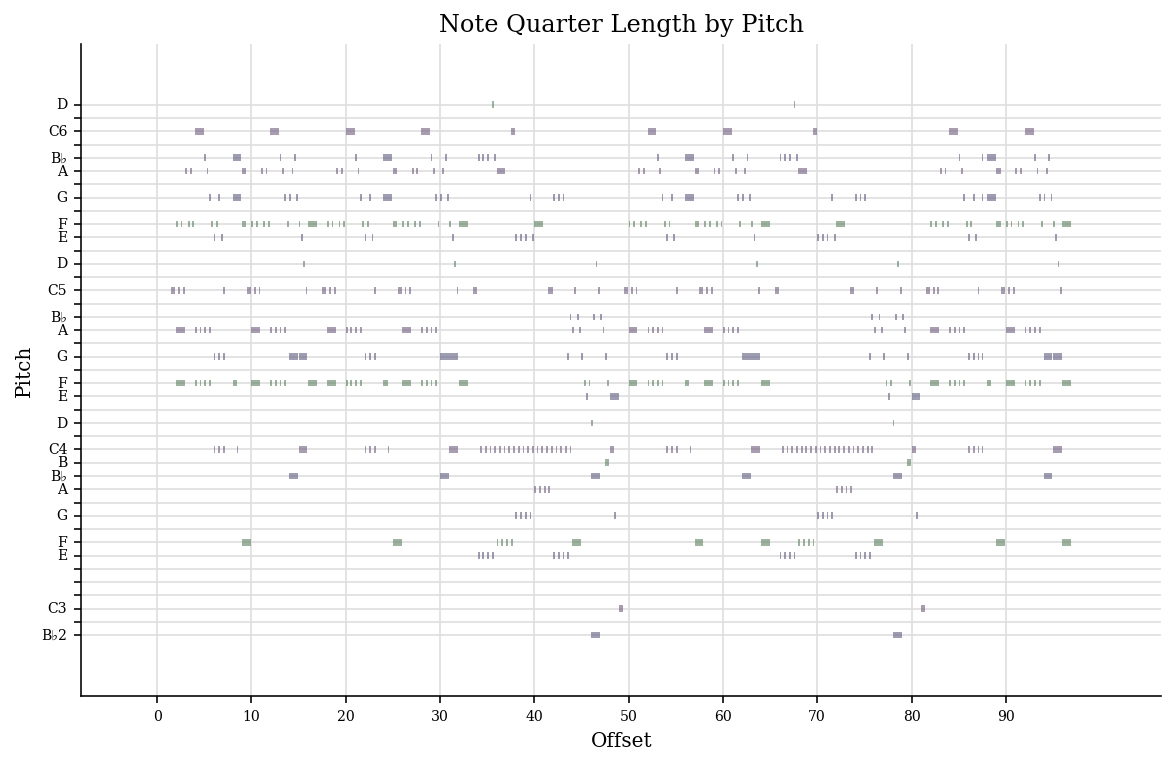

In [7]:
music = music21.converter.parse('classical_music_midi/haydn/haydn_9_3.mid')
music.plot()

The convert_midi_to_flac function is able to convert the midi file to be listenable by using a soundfont file.

In [8]:
def convert_midi_to_flac(music_path, output='music'):
  FluidSynth('piano.sf2').midi_to_audio(music_path, 'music' + '.flac')
  return 'music' + '.flac'

def play_music(music_path):
  convert_midi_to_flac(music_path, output='music')
  return 'music.flac'

In [9]:
Audio(play_music('classical_music_midi/haydn/haydn_9_3.mid'))

---
## 3. Load Data Frame

Load dataframe which was already created in the *Create_DataFrame.ipynb* file.<br>

In [22]:
dataset = pd.read_pickle('./dataset.pkl')
dataset

pitches   velocity  \
haydn/haydn_9_3.mid  0                                 [72]  40.000000   
                     1                         [65, 69, 77]  35.666667   
                     2                                 [72]  40.000000   
                     3                                 [77]  41.000000   
                     4                                 [72]  42.000000   
...                                                     ...        ...   
liszt/liz_rhap12.mid 3105  [44, 48, 51, 56, 75, 80, 84, 87]  77.375000   
                     3106  [37, 41, 44, 49, 77, 80, 85, 89]  77.375000   
                     3107  [32, 36, 39, 44, 80, 84, 87, 92]  77.375000   
                     3108  [37, 41, 44, 49, 85, 89, 92, 97]  77.375000   
                     3109  [54, 58, 61, 66, 73, 78, 82, 85]  80.875000   

                           duration  
haydn/haydn_9_3.mid  0     0.251446  
                     1     0.127866  
                     2     0.127866  
                     3     0.127866  
                     4     0.127866  
...                             ...  
liszt/liz_rhap12.mid 3105  0.277136  
                     3106  0.277136  
                     3107  0.277137  
                     3108  1.078652  
                     3109  1.136797  

[357130 rows x 3 columns]

Optionally, we can choose the used pieces at this step.<br>
*For instance we can use only the ones, where the composer is Mozart.*

In [23]:
dataset = dataset.filter(like='mozart', axis=0)
dataset.index

MultiIndex([('mozart/mz_332_2.mid',    0),
            ('mozart/mz_332_2.mid',    1),
            ('mozart/mz_332_2.mid',    2),
            ('mozart/mz_332_2.mid',    3),
            ('mozart/mz_332_2.mid',    4),
            ('mozart/mz_332_2.mid',    5),
            ('mozart/mz_332_2.mid',    6),
            ('mozart/mz_332_2.mid',    7),
            ('mozart/mz_332_2.mid',    8),
            ('mozart/mz_332_2.mid',    9),
            ...
            ('mozart/mz_332_3.mid', 3969),
            ('mozart/mz_332_3.mid', 3970),
            ('mozart/mz_332_3.mid', 3971),
            ('mozart/mz_332_3.mid', 3972),
            ('mozart/mz_332_3.mid', 3973),
            ('mozart/mz_332_3.mid', 3974),
            ('mozart/mz_332_3.mid', 3975),
            ('mozart/mz_332_3.mid', 3976),
            ('mozart/mz_332_3.mid', 3977),
            ('mozart/mz_332_3.mid', 3978)],
           length=43160)

In [24]:
dataset.describe()

velocity      duration
count  43160.000000  43160.000000
mean      51.598079      0.195721
std       12.528612      0.167730
min       21.000000      0.000758
25%       43.000000      0.104895
50%       51.000000      0.164710
75%       60.000000      0.232558
max      108.000000      6.539590

# 4. Prepare data

Scale duration and velocity columns.

In [25]:
scaler = MinMaxScaler()
scaler.fit(dataset[['duration', 'velocity']])
scaled = scaler.transform(dataset[['duration', 'velocity']])

dataset[['duration', 'velocity']] = scaler.transform(dataset[['duration', 'velocity']])
dataset.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


velocity      duration
count  43160.000000  43160.000000
mean       0.351702      0.029816
std        0.144007      0.025651
min        0.000000      0.000000
25%        0.252874      0.015926
50%        0.344828      0.025074
75%        0.448276      0.035450
max        1.000000      1.000000

Tokenize pitches.

In [26]:
def create_token_from_pitches(pitches):
  note = np.zeros(108-21, dtype=int)
  for pitch in pitches:
    note[pitch - 21] = 1
  return note

dataset['pitches'] = dataset['pitches'].apply(create_token_from_pitches)
dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


pitches  \
mozart/mz_332_2.mid 0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                                     ...   
mozart/mz_332_3.mid 3974  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    3975  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    3976  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    3977  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                    3978  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                          velocity  duration  
mozart/mz_332_2.mid 0     0.252874  0.061336  
                    1     0.068966  0.061336  
                    2     0.068966  0.061336  
                    3     0.068966  0.061336  
                    4     0.252874  0.061336  
...                            ...       ...  
mozart/mz_332_3.mid 3974  0.132184  0.034192  
                    3975  0.172414  0.032658  
                    3976  0.126437  0.041597  
                    3977  0.126437  0.066774  
                    3978  0.129310  0.243106  

[43160 rows x 3 columns]

Window dataset

In [27]:
window_size = 32

In [28]:
def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries.shape[0])
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    Y = timeseries[window_size:]
    return X, Y

In [29]:
X_dur_vel, Y_dur_vel = make_timeseries_instances(dataset[['duration', 'velocity']], window_size=window_size)
# Check
assert (X_dur_vel[window_size][0] == Y_dur_vel[0]).all()
X_dur_vel.shape, Y_dur_vel.shape

((43128, 32, 2), (43128, 2))

In [30]:
X_pitches, Y_pitches = make_timeseries_instances(np.array([arr for arr in dataset['pitches'].values]), window_size=window_size)
assert (X_pitches[window_size][0] == Y_pitches[0]).all()
X_pitches.shape, Y_pitches.shape

((43128, 32, 87), (43128, 87))



---
# 5. Create and train model


In [31]:
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv2D, Flatten, Reshape, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

## Create model

First create a model for handling input pitches.

In [32]:
pitch_input = Input(shape=(window_size, 108-21), name='pitch_input')

lstm = LSTM(320, name='pitch_in_lstm', activation='relu', kernel_initializer='he_normal', dropout=0.2)(pitch_input)
dense = Dense(1000, activation="relu", kernel_initializer='he_normal', name='pitch_in_dense')(lstm)
dropout = Dropout(0.3)(dense)
output = Dense(200, activation="relu", kernel_initializer='he_normal', name='pitch_in_out')(dropout)
model_pitch_in = Model(inputs=pitch_input, outputs=output, name="model_pitch_in")

model_pitch_in.summary()

Model: "model_pitch_in"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pitch_input (InputLayer)    [(None, 32, 87)]          0         
                                                                 
 pitch_in_lstm (LSTM)        (None, 320)               522240    
                                                                 
 pitch_in_dense (Dense)      (None, 1000)              321000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 pitch_in_out (Dense)        (None, 200)               200200    
                                                                 
Total params: 1,043,440
Trainable params: 1,043,440
Non-trainable params: 0
_________________________________________________________________


Secondly create another model, which handles the duration and velocity inputs.

In [33]:
dur_vel_input = Input(shape=(window_size, 2), name='dur_vel_input')

# the second branch opreates on the duration and velocity inputs
lstm = LSTM(32, name='dur_vel_in_lstm')(dur_vel_input)
dense = Dense(50, activation="relu", kernel_initializer='he_normal', name='dur_vel_in_dense_1')(lstm)
dropout = Dropout(0.3)(dense)
output = Dense(50, activation="relu", kernel_initializer='he_normal', name='dur_vel_in_out')(dropout)
model_dur_vel_in = Model(inputs=dur_vel_input, outputs=output, name='model_dur_vel_in')

model_dur_vel_in.summary()

Model: "model_dur_vel_in"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dur_vel_input (InputLayer)  [(None, 32, 2)]           0         
                                                                 
 dur_vel_in_lstm (LSTM)      (None, 32)                4480      
                                                                 
 dur_vel_in_dense_1 (Dense)  (None, 50)                1650      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dur_vel_in_out (Dense)      (None, 50)                2550      
                                                                 
Total params: 8,680
Trainable params: 8,680
Non-trainable params: 0
_________________________________________________________________


Finally, combine these two models and define 2 outputs. One for pitches and one for the duration and velocity values.

In [35]:
# combine the output of the two branches
common_input = concatenate([model_pitch_in.output, model_dur_vel_in.output], name='common_input')

# common branch
common_dense = Dense(300, activation="relu", name='common_dense_1', kernel_initializer='he_normal')(common_input)
dropout = Dropout(0.3)(common_dense)

# outputs
pitch_output = Dense(108-21, activation="sigmoid", name='pitch_output')(dropout)
dur_vel_output = Dense(2, activation='sigmoid', name='dur_vel_output')(dropout)

# define model
model = Model(inputs=[model_pitch_in.input, model_dur_vel_in.input], outputs=[pitch_output, dur_vel_output], name='model')

model.compile(optimizer='adam', 
              loss={'pitch_output': 'binary_crossentropy', 'dur_vel_output': 'mean_squared_error'},
              loss_weights={'pitch_output': 1., 'dur_vel_output': 0.2},
              metrics={'pitch_output': 'acc', 'dur_vel_output': None})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pitch_input (InputLayer)       [(None, 32, 87)]     0           []                               
                                                                                                  
 dur_vel_input (InputLayer)     [(None, 32, 2)]      0           []                               
                                                                                                  
 pitch_in_lstm (LSTM)           (None, 320)          522240      ['pitch_input[0][0]']            
                                                                                                  
 dur_vel_in_lstm (LSTM)         (None, 32)           4480        ['dur_vel_input[0][0]']          
                                                                                              

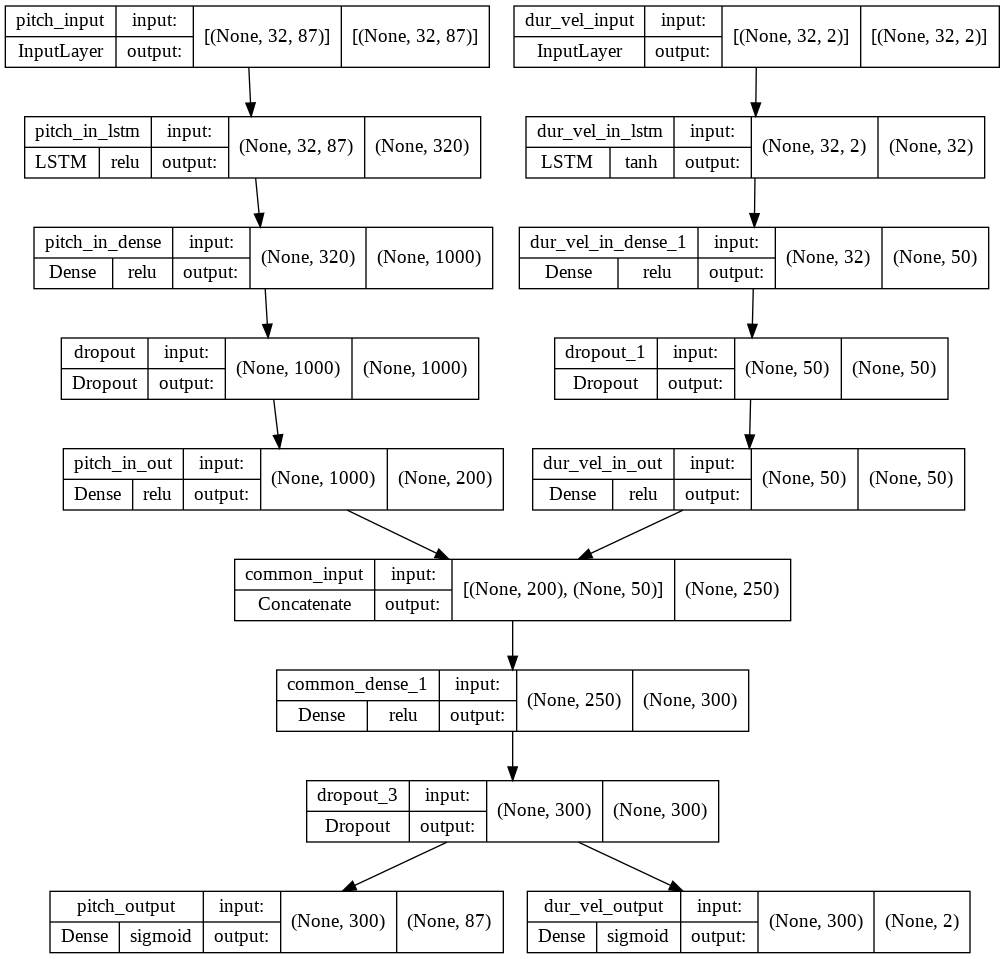

In [36]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

## Train model

In [26]:
from keras.callbacks import LambdaCallback

def printLog(epoch, logs):
  print('Epoch ', epoch, ':', sep='')
  if 'loss' in logs:
    print('\tloss: {:.4f}'.format(logs['loss']), end='\t\t\t')
    print('val_loss: {:.4f}'.format(logs['val_loss']))
  if 'pitch_output_loss' in logs:
    print('\tpitch loss: {:.4f}, acc: {:.4f}'.format(logs['pitch_output_loss'], logs['pitch_output_acc']), end='\t')
    print('val_loss: {:.4f}, val_acc: {:.4f}'.format(logs['val_pitch_output_loss'], logs['val_pitch_output_acc']))
  if 'pitch_output_loss' in logs:
    print('\tdur_vel loss: {:.4f}'.format(logs['dur_vel_output_loss']), end='\t\t')
    print('val_loss: {:.4f}'.format(logs['val_dur_vel_output_loss']))

printerCallback = LambdaCallback(on_epoch_end=printLog)

In [37]:
es = keras.callbacks.EarlyStopping(patience=500, monitor='val_pitch_output_acc', restore_best_weights=True, verbose=10)
model.fit([X_pitches, X_dur_vel], [Y_pitches, Y_dur_vel], epochs=100000, callbacks=[es], batch_size=2048, validation_split=0.1)

Epoch 1/100000
19/19 [==============================] - 97s 5s/step - loss: 0.2583 - pitch_output_loss: 0.2490 - dur_vel_output_loss: 0.0465 - pitch_output_acc: 0.0194 - val_loss: 0.0800 - val_pitch_output_loss: 0.0761 - val_dur_vel_output_loss: 0.0194 - val_pitch_output_acc: 0.0297
Epoch 2/100000
19/19 [==============================] - 90s 5s/step - loss: 0.0954 - pitch_output_loss: 0.0897 - dur_vel_output_loss: 0.0285 - pitch_output_acc: 0.0377 - val_loss: 0.0762 - val_pitch_output_loss: 0.0739 - val_dur_vel_output_loss: 0.0116 - val_pitch_output_acc: 0.0329
Epoch 3/100000
19/19 [==============================] - 90s 5s/step - loss: 0.0882 - pitch_output_loss: 0.0842 - dur_vel_output_loss: 0.0197 - pitch_output_acc: 0.0420 - val_loss: 0.0739 - val_pitch_output_loss: 0.0725 - val_dur_vel_output_loss: 0.0073 - val_pitch_output_acc: 0.0329
Epoch 4/100000
19/19 [==============================] - 91s 5s/step - loss: 0.0839 - pitch_output_loss: 0.0812 - dur_vel_output_loss: 0.0139 - pitch

KeyboardInterrupt: ignored

Save model

In [ ]:
from datetime import datetime
import subprocess

# Save model
path = "models/" + str(datetime.now().strftime("%m-%d-%Y_%H-%M-%S"))
model.save(path)

# Zip model to be downloadable
subprocess.call(['zip', '-r', path + ".zip", path])

INFO:tensorflow:Assets written to: models/04-15-2022_20-32-08/assets


INFO:tensorflow:Assets written to: models/04-15-2022_20-32-08/assets


0



---
# 5. Generate music

In [38]:
def generate(num, model, win):
  pitches = np.zeros((num + win, 108-21), dtype=int)
  dur_vel = np.zeros((num + win, 2))
  pitches[:win] = X_pitches[0]
  dur_vel[:win] = X_dur_vel[0]
  for i in range(num):
    x_pitches = np.expand_dims(pitches[i:i+win], axis=0)
    x_dur_vel = np.expand_dims(dur_vel[i:i+win], axis=0)
    pred_pitches, pred_dur_vel = model.predict([x_pitches, x_dur_vel])
    pitches[i+win] = __binarize_pitches(pred_pitches[0])
    dur_vel[i+win] = pred_dur_vel
  dur_vel = scaler.inverse_transform(dur_vel)
  pitches = __get_pitches_from_vectors(pitches)
  return pd.DataFrame({'pitches': pitches, 'duration': dur_vel[:, 0], 'velocity': np.round(dur_vel[:, 1])})

def __binarize_pitches(pred):
  pitches = np.argwhere(pred >= 0.5).reshape(-1)
  if len(pitches) == 0:
    pitches = np.expand_dims(np.argmax(pred), 0)
  elif len(pitches) > 10:
    pitches = np.argsort(pred)[-10:]
  result = np.zeros((108-21), dtype=int)
  for pitch in pitches:
    result[pitch] = 1
  return result

def __get_pitches_from_vectors(vectors):
  result = []
  for vec in vectors:
    result.append(np.argwhere(vec == 1).reshape(-1) + 21)
  return result

generated = generate(1024, model, window_size)
generated

pitches  duration  velocity
0     [58, 70]  0.401821      43.0
1         [65]  0.401821      27.0
2         [62]  0.401821      27.0
3         [65]  0.401822      27.0
4     [58, 74]  0.401821      43.0
...        ...       ...       ...
1051      [58]  0.178110      42.0
1052      [58]  0.178110      42.0
1053      [58]  0.178110      42.0
1054      [58]  0.178110      42.0
1055      [58]  0.178110      42.0

[1056 rows x 3 columns]

In [39]:
from pretty_midi import Note

music = pretty_midi.PrettyMIDI()
piano = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))

start = 0
for index, note in generated.iterrows():
  for pitch in note['pitches']:
    piano.notes.append(Note(pitch=pitch,
                            velocity=int(note['velocity']), 
                            start=start, 
                            end=start+note['duration']))
  start += note['duration']

# Add the piano instrument to the PrettyMIDI object
music.instruments.append(piano)
# Write out the MIDI data
music.write('output.mid')

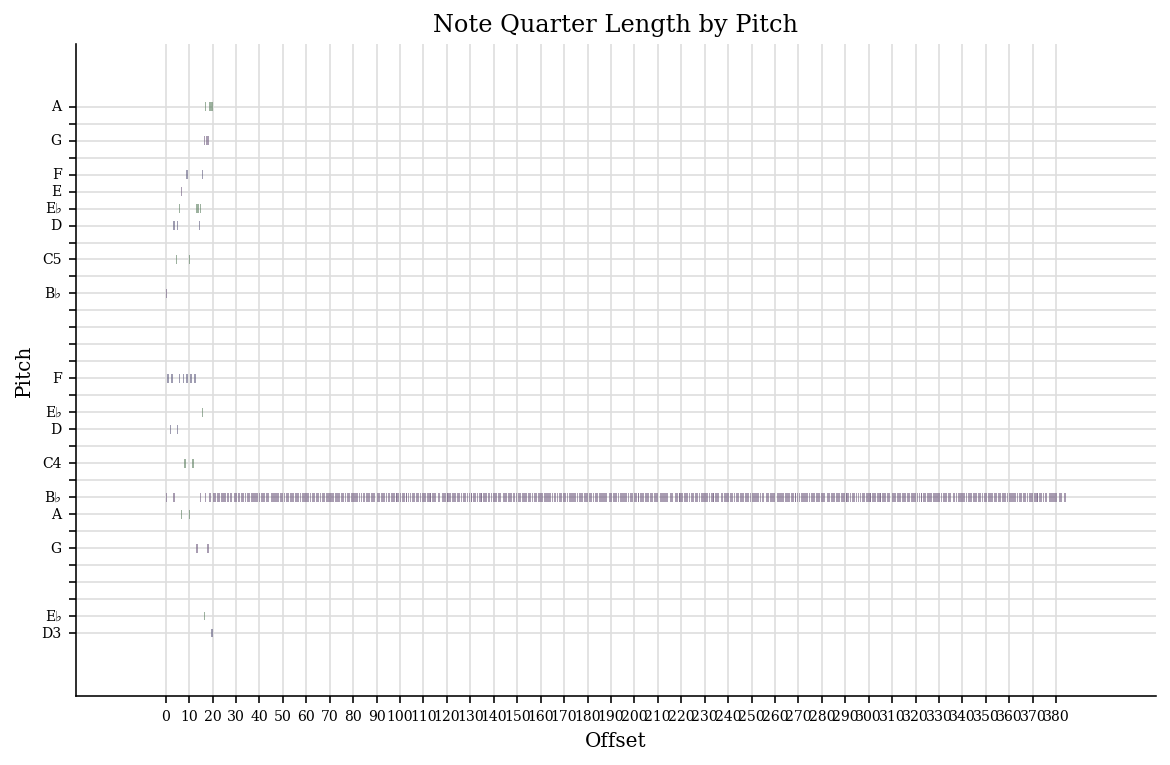

In [40]:
music = music21.converter.parse('output.mid')
music.plot()

In [41]:
Audio(play_music('output.mid'))